In [2]:
import typing
import json
import glob

import numpy
import pandas 

import scipy
import statsmodels
import statsmodels.stats
import statsmodels.stats.descriptivestats

import seaborn

import llm_questionnaires as llmq

In [3]:
MODELS: typing.List[str] = llmq.CONSTANTS.MODELS
MODELS

['llama3.1-8b',
 'llama3.3-70b',
 'mistral-7b',
 'mistral-large-123b',
 'qwen2.5-7b',
 'qwen2.5-72b']

In [4]:
COLUMNS: typing.List[str] = [
    [str(quest["dimension"][:2].upper()) + str(quest["dimension"][4].upper()) + str(quest["id"]) for quest in
    json.load(open("../../../data/humor_styles/questionnaire.json"))[0]["questions"]]
]

In [5]:
raw: typing.Dict[str, pandas.DataFrame]= {
    **llmq.evaluation.read_populations("data/base", MODELS, COLUMNS),
    "human_full": (
        pandas.read_csv("../../../data/humor_styles/survey.csv")
        .rename_axis(index="participant")
        .filter(like='Q', axis=1)
        .replace(-1, None)
        .apply(pandas.to_numeric)
        .set_axis(COLUMNS, axis=1)
    ),
    "random": (
        pandas.DataFrame(numpy.random.randint(0,5, (1000, 32)), columns=range(1,33))
        .rename_axis(index="participant")
        .set_axis(COLUMNS, axis=1)
    )
}

raw.keys()

dict_keys(['llama3.1-8b', 'llama3.3-70b', 'mistral-7b', 'mistral-large-123b', 'qwen2.5-7b', 'qwen2.5-72b', 'human_full', 'random'])

In [6]:
for key, values in raw.items():
    values.to_csv(f"reports/raw.{key}.csv", index=False)

In [7]:
descriptive = pandas.concat({
    key: statsmodels.stats.descriptivestats.describe(values).T
    for key, values in raw.items()
})
descriptive

/home/ubuntu/repositories/LLM-Questionnaires/.venv/lib/python3.12/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/home/ubuntu/repositories/LLM-Questionnaires/.venv/lib/python3.12/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)


nobs  missing      mean   std_err  upper_ci  lower_ci  \
llama3.1-8b AFL1   1000.0     15.0  2.506599  0.039158  2.583348  2.429850   
            SEE2   1000.0     15.0  2.254822  0.042601  2.338319  2.171325   
            AGE3   1000.0     30.0  3.652577  0.038620  3.728271  3.576883   
            SED4   1000.0      5.0  2.976884  0.052253  3.079299  2.874470   
            AFL5   1000.0     12.0  3.451417  0.050294  3.549992  3.352842   
...                   ...      ...       ...       ...       ...       ...   
random      SED28  1000.0      0.0  1.976000  0.045183  2.064556  1.887444   
            AFL29  1000.0      0.0  2.062000  0.044566  2.149348  1.974652   
            SEE30  1000.0      0.0  2.051000  0.043776  2.136799  1.965201   
            AGE31  1000.0      0.0  1.962000  0.044995  2.050189  1.873811   
            SED32  1000.0      0.0  2.051000  0.044636  2.138485  1.963515   

                        std  iqr  iqr_normal       mad  ...  median   1%   5%  \
llama3.1-8b AFL1   1.228972  1.0    0.741301  1.054083  ...     2.0  1.0  1.0   
            SEE2   1.337027  2.0    1.482602  1.085787  ...     2.0  1.0  1.0   
            AGE3   1.202817  1.0    0.741301  0.919885  ...     4.0  1.0  1.0   
            SED4   1.648262  4.0    2.965204  1.504534  ...     3.0  1.0  1.0   
            AFL5   1.580872  3.0    2.223903  1.435616  ...     4.0  1.0  1.0   
...                     ...  ...         ...       ...  ...     ...  ...  ...   
random      SED28  1.428799  2.0    1.482602  1.226368  ...     2.0  0.0  0.0   
            AFL29  1.409306  2.0    1.482602  1.210168  ...     2.0  0.0  0.0   
            SEE30  1.384310  2.0    1.482602  1.179568  ...     2.0  0.0  0.0   
            AGE31  1.422878  2.0    1.482602  1.216460  ...     2.0  0.0  0.0   
            SED32  1.411521  2.0    1.482602  1.207262  ...     2.0  0.0  0.0   

                   10%  25%  50%  75%  90%  95%  99%  
llama3.1-8b AFL1   1.0  2.0  2.0  3.0  4.0  5.0  5.0  
            SEE2   1.0  1.0  2.0  3.0  5.0  5.0  5.0  
            AGE3   1.0  3.0  4.0  4.0  5.0  5.0  5.0  
            SED4   1.0  1.0  3.0  5.0  5.0  5.0  5.0  
            AFL5   1.0  2.0  4.0  5.0  5.0  5.0  5.0  
...                ...  ...  ...  ...  ...  ...  ...  
random      SED28  0.0  1.0  2.0  3.0  4.0  4.0  4.0  
            AFL29  0.0  1.0  2.0  3.0  4.0  4.0  4.0  
            SEE30  0.0  1.0  2.0  3.0  4.0  4.0  4.0  
            AGE31  0.0  1.0  2.0  3.0  4.0  4.0  4.0  
            SED32  0.0  1.0  2.0  3.0  4.0  4.0  4.0  

[256 rows x 31 columns]

In [8]:
raw["human_sampled"] = (
    pandas.DataFrame(numpy.stack([
        numpy.random.normal(row["mean"], row["std"], 1000).astype(int)
        for _, row in descriptive.loc["human_full"][["mean", "std"]].iterrows()
    ], axis=1), columns=range(1,33))
    .rename_axis(index="participant")
    .set_axis(COLUMNS, axis=1)
)

In [9]:
pandas.concat({
    (key_1, key_2): (
        pandas.Series(
            scipy
            .stats.f_oneway(
                values_1,
                values_2,
                nan_policy="omit"
            )
            .pvalue
            > 0.05,
            name="f_oneway_significant"
        )
        .value_counts()
    )
    for key_1, values_1 in raw.items()
    for key_2, values_2 in raw.items()
}).to_frame()

/home/ubuntu/repositories/LLM-Questionnaires/.venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:618: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


count
                            f_oneway_significant       
llama3.1-8b   llama3.1-8b   True                     22
                            False                    10
              llama3.3-70b  False                    30
                            True                      2
              mistral-7b    False                    26
...                                                 ...
human_sampled qwen2.5-72b   False                    32
              human_full    False                    32
              random        False                    31
                            True                      1
              human_sampled True                     32

[144 rows x 1 columns]

In [18]:
sim: pandas.DataFrame = (
    llmq.evaluation.apply_calc_similarity(raw)
    .to_frame()
    .reset_index(level=[0, 1])
    .pivot_table(values="similarity", index="level_0", columns="level_1")
    .reindex(
        columns=(idx := ["random", "human_sampled", "human_full", *MODELS]),
        index=idx
    )
    .pipe(llmq.evaluation.extract_triu_df)
)
sim

print(sim.pipe(llmq.evaluation.format_latex_df))
print({
    "mean": sim.stack().mean(),
    "std": sim.stack().std()
})

\begin{tabular}{lrrrrrrrrr}
\toprule
level_1 & \rotatebox{65}{random} & \rotatebox{65}{human\_sampled} & \rotatebox{65}{human\_full} & \rotatebox{65}{llama3.1-8b} & \rotatebox{65}{llama3.3-70b} & \rotatebox{65}{mistral-7b} & \rotatebox{65}{mistral-large-123b} & \rotatebox{65}{qwen2.5-7b} & \rotatebox{65}{qwen2.5-72b} \\
level_0 &  &  &  &  &  &  &  &  &  \\
\midrule
random &  &  &  &  &  &  &  &  &  \\
human\_sampled & 0.033 &  &  &  &  &  &  &  &  \\
human\_full & 0.009 & -0.021 &  &  &  &  &  &  &  \\
llama3.1-8b & 0.050 & -0.002 & -0.022 &  &  &  &  &  &  \\
llama3.3-70b & 0.014 & -0.012 & 0.006 & -0.028 &  &  &  &  &  \\
mistral-7b & -0.003 & 0.035 & 0.085 & -0.036 & -0.047 &  &  &  &  \\
mistral-large-123b & -0.067 & -0.036 & 0.130 & -0.047 & 0.054 & 0.044 &  &  &  \\
qwen2.5-7b & 0.099 & 0.067 & 0.164 & -0.027 & 0.085 & -0.020 & 0.070 &  &  \\
qwen2.5-72b & -0.005 & 0.014 & -0.068 & 0.082 & -0.020 & 0.040 & 0.053 & 0.034 &  \\
\bottomrule
\end{tabular}

{'mean': np.float64(0.0196

In [22]:
(
    sim
    .filter(like="human")
    .stack()
    .mean()
)

np.float64(0.026232139214380924)

<Axes: xlabel='level_1', ylabel='level_0'>

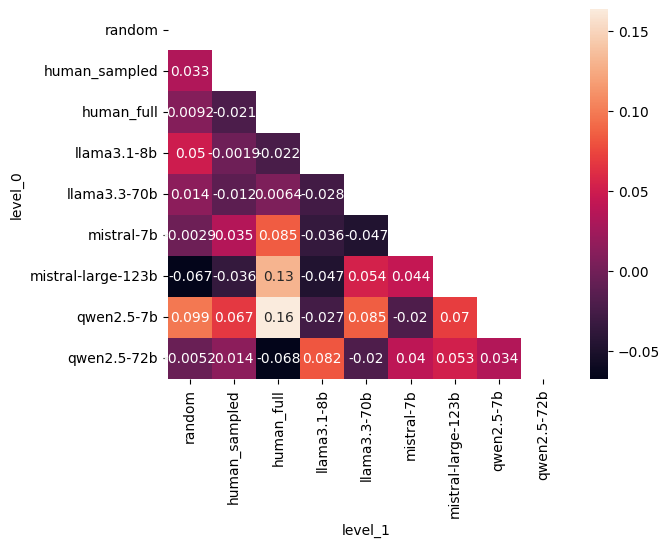

In [12]:
seaborn.heatmap(sim, annot=True, mask=numpy.triu(sim))

In [23]:
human_chunked = {
    f"{n:02d}": chunk
    for n, chunk in enumerate(numpy.array_split(raw["human_full"].sample(frac=1.0), 10), start=1)
}

sim = (
    llmq.evaluation.apply_calc_similarity(human_chunked)
    .to_frame()
    .reset_index(level=[0,1])
    .pivot_table(values="similarity", index="level_0", columns="level_1")
    .pipe(llmq.evaluation.extract_triu_df)
    
)
sim

print(sim.pipe(llmq.evaluation.format_latex_df))
print({
    "mean": sim.stack().mean(),
    "std": sim.stack().std()
})

\begin{tabular}{lrrrrrrrrrr}
\toprule
level_1 & \rotatebox{65}{01} & \rotatebox{65}{02} & \rotatebox{65}{03} & \rotatebox{65}{04} & \rotatebox{65}{05} & \rotatebox{65}{06} & \rotatebox{65}{07} & \rotatebox{65}{08} & \rotatebox{65}{09} & \rotatebox{65}{10} \\
level_0 &  &  &  &  &  &  &  &  &  &  \\
\midrule
01 &  &  &  &  &  &  &  &  &  &  \\
02 & 0.783 &  &  &  &  &  &  &  &  &  \\
03 & 0.799 & 0.812 &  &  &  &  &  &  &  &  \\
04 & 0.789 & 0.830 & 0.809 &  &  &  &  &  &  &  \\
05 & 0.810 & 0.864 & 0.834 & 0.859 &  &  &  &  &  &  \\
06 & 0.818 & 0.853 & 0.824 & 0.822 & 0.858 &  &  &  &  &  \\
07 & 0.802 & 0.852 & 0.819 & 0.822 & 0.841 & 0.847 &  &  &  &  \\
08 & 0.787 & 0.784 & 0.815 & 0.788 & 0.814 & 0.810 & 0.772 &  &  &  \\
09 & 0.781 & 0.853 & 0.825 & 0.842 & 0.858 & 0.811 & 0.842 & 0.793 &  &  \\
10 & 0.803 & 0.875 & 0.823 & 0.855 & 0.912 & 0.868 & 0.836 & 0.817 & 0.859 &  \\
\bottomrule
\end{tabular}

{'mean': np.float64(0.8259998789592642), 'std': np.float64(0.02987427355642331)

/home/ubuntu/repositories/LLM-Questionnaires/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
